In [391]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import sys

# Add src to path
sys.path.append('../src')

In [392]:
from data_cleaning import DataCleaner
from feature_engineering import FeatureEngineer

In [393]:
# Cell 3: Initialize and load data
print("Initializing DataCleaner...")
try:
    cleaner = DataCleaner()
    print("DataCleaner initialized successfully!")
    
    print("Loading data...")
    df_raw = cleaner.load_data()
    print("Dataset shape:", df_raw.shape)
    print("\nFirst few rows:")
    display(df_raw.head())
    
except FileNotFoundError as e:
    print(f"Error: {e}")
    print("\nTrying alternative approach...")
    
    # Manual loading as fallback
    import pandas as pd
    import os
    
    # Try to find the CSV file
    possible_paths = [
        '../data/raw/diabetes.csv',
        './data/raw/diabetes.csv',
        'diabetes.csv',
        '../diabetes.csv'
    ]
    
    for path in possible_paths:
        if os.path.exists(path):
            df_raw = pd.read_csv(path)
            print(f"Found data at: {path}")
            print("Dataset shape:", df_raw.shape)
            print("\nFirst few rows:")
            display(df_raw.head())
            break
    else:
        print("Could not find diabetes.csv file. Please ensure it's in the correct location.")
        
except Exception as e:
    print(f"Unexpected error: {e}")

Initializing DataCleaner...
Error: [Errno 2] No such file or directory: 'config/config.yaml'

Trying alternative approach...
Found data at: ../data/raw/diabetes.csv
Dataset shape: (768, 9)

First few rows:


,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


In [394]:
print("=== INITIAL DATA ASSESSMENT ===")
print("\nData Types:")
print(df_raw.dtypes)
print("\nMissing Values (original):")
print(df_raw.isnull().sum())
print("\nBasic Statistics:")
display(df_raw.describe())

=== INITIAL DATA ASSESSMENT ===

Data Types:
Pregnancies                   int64
Glucose                       int64
BloodPressure                 int64
SkinThickness                 int64
Insulin                       int64
BMI                         float64
DiabetesPedigreeFunction    float64
Age                           int64
Outcome                       int64
dtype: object

Missing Values (original):
Pregnancies                 0
Glucose                     0
BloodPressure               0
SkinThickness               0
Insulin                     0
BMI                         0
DiabetesPedigreeFunction    0
Age                         0
Outcome                     0
dtype: int64

Basic Statistics:


,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
count,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000
mean,3.845052,120.894531,69.105469,20.536458,79.799479,31.992578,0.471876,33.240885,0.348958
std,3.369578,31.972618,19.355807,15.952218,115.244002,7.884160,0.331329,11.760232,0.476951
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.078000,21.000000,0.000000
25%,1.000000,99.000000,62.000000,0.000000,0.000000,27.300000,0.243750,24.000000,0.000000
50%,3.000000,117.000000,72.000000,23.000000,30.500000,32.000000,0.372500,29.000000,0.000000
75%,6.000000,140.250000,80.000000,32.000000,127.250000,36.600000,0.626250,41.000000,1.000000
max,17.000000,199.000000,122.000000,99.000000,846.000000,67.100000,2.420000,81.000000,1.000000


In [395]:
print("=== BIOLOGICAL IMPOSSIBILITIES ANALYSIS ===")
# Features where zero values are biologically impossible
biological_features = ['Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI']

missing_report = {}
for feature in biological_features:
    if feature in df_raw.columns:
        zero_count = (df_raw[feature] == 0).sum()
        missing_report[feature] = {
            'zero_count': zero_count,
            'percentage': (zero_count / len(df_raw)) * 100
        }
        print(f"{feature}: {zero_count} zeros ({missing_report[feature]['percentage']:.2f}%)")


=== BIOLOGICAL IMPOSSIBILITIES ANALYSIS ===
Glucose: 5 zeros (0.65%)
BloodPressure: 35 zeros (4.56%)
SkinThickness: 227 zeros (29.56%)
Insulin: 374 zeros (48.70%)
BMI: 11 zeros (1.43%)


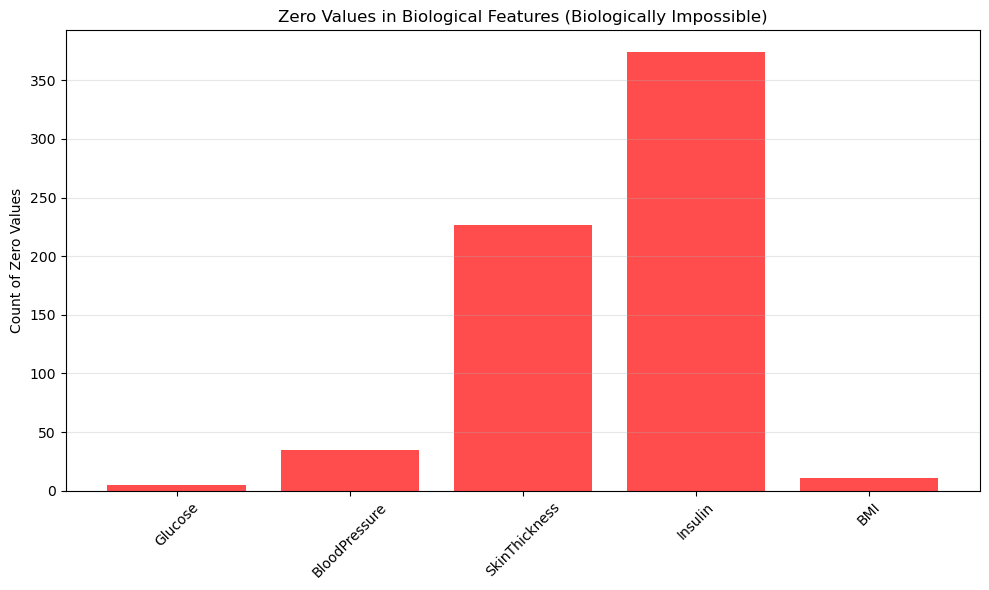

In [396]:
plt.figure(figsize=(10, 6))
zero_counts = [stats['zero_count'] for stats in missing_report.values()]
features = list(missing_report.keys())
plt.bar(features, zero_counts, color='red', alpha=0.7)
plt.title('Zero Values in Biological Features (Biologically Impossible)')
plt.xticks(rotation=45)
plt.ylabel('Count of Zero Values')
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

In [397]:
print("=== HANDLING MISSING VALUES ===")
df_clean = df_raw.copy()

# Replace zeros with NaN in biological features
for feature in biological_features:
    if feature in df_clean.columns:
        df_clean[feature] = df_clean[feature].replace(0, np.nan)

print("Missing values after replacing zeros with NaN:")
print(df_clean.isnull().sum())

# Impute missing values with median
for feature in biological_features:
    if feature in df_clean.columns:
        median_val = df_clean[feature].median()
        df_clean[feature].fillna(median_val, inplace=True)
        print(f"Imputed {feature} with median: {median_val:.2f}")

print("\nMissing values after imputation:")
print(df_clean.isnull().sum())

=== HANDLING MISSING VALUES ===
Missing values after replacing zeros with NaN:
Pregnancies                   0
Glucose                       5
BloodPressure                35
SkinThickness               227
Insulin                     374
BMI                          11
DiabetesPedigreeFunction      0
Age                           0
Outcome                       0
dtype: int64
Imputed Glucose with median: 117.00
Imputed BloodPressure with median: 72.00
Imputed SkinThickness with median: 29.00
Imputed Insulin with median: 125.00
Imputed BMI with median: 32.30

Missing values after imputation:
Pregnancies                 0
Glucose                     0
BloodPressure               0
SkinThickness               0
Insulin                     0
BMI                         0
DiabetesPedigreeFunction    0
Age                         0
Outcome                     0
dtype: int64


C:\Users\USER\AppData\Local\Temp\ipykernel_238828\2622990903.py:16: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_clean[feature].fillna(median_val, inplace=True)


In [398]:
print("=== OUTLIER DETECTION ===")
def detect_outliers_iqr(df, features):
    outlier_report = {}
    for feature in features:
        if feature in df.columns:
            Q1 = df[feature].quantile(0.25)
            Q3 = df[feature].quantile(0.75)
            IQR = Q3 - Q1
            lower_bound = Q1 - 1.5 * IQR
            upper_bound = Q3 + 1.5 * IQR
            
            outliers = df[(df[feature] < lower_bound) | (df[feature] > upper_bound)]
            outlier_report[feature] = {
                'count': len(outliers),
                'percentage': (len(outliers) / len(df)) * 100,
                'lower_bound': lower_bound,
                'upper_bound': upper_bound,
                'min_value': df[feature].min(),
                'max_value': df[feature].max()
            }
    return outlier_report

numerical_features = ['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness', 
                     'Insulin', 'BMI', 'DiabetesPedigreeFunction', 'Age']

outlier_report = detect_outliers_iqr(df_clean, numerical_features)

print("Outlier Report:")
for feature, stats in outlier_report.items():
    print(f"{feature}: {stats['count']} outliers ({stats['percentage']:.2f}%)")
    print(f"  Range: [{stats['min_value']:.2f}, {stats['max_value']:.2f}]")
    print(f"  Bounds: [{stats['lower_bound']:.2f}, {stats['upper_bound']:.2f}]")

=== OUTLIER DETECTION ===
Outlier Report:
Pregnancies: 4 outliers (0.52%)
  Range: [0.00, 17.00]
  Bounds: [-6.50, 13.50]
Glucose: 0 outliers (0.00%)
  Range: [44.00, 199.00]
  Bounds: [39.00, 201.00]
BloodPressure: 14 outliers (1.82%)
  Range: [24.00, 122.00]
  Bounds: [40.00, 104.00]
SkinThickness: 87 outliers (11.33%)
  Range: [7.00, 99.00]
  Bounds: [14.50, 42.50]
Insulin: 346 outliers (45.05%)
  Range: [14.00, 846.00]
  Bounds: [112.88, 135.88]
BMI: 8 outliers (1.04%)
  Range: [18.20, 67.10]
  Bounds: [13.85, 50.25]
DiabetesPedigreeFunction: 29 outliers (3.78%)
  Range: [0.08, 2.42]
  Bounds: [-0.33, 1.20]
Age: 9 outliers (1.17%)
  Range: [21.00, 81.00]
  Bounds: [-1.50, 66.50]


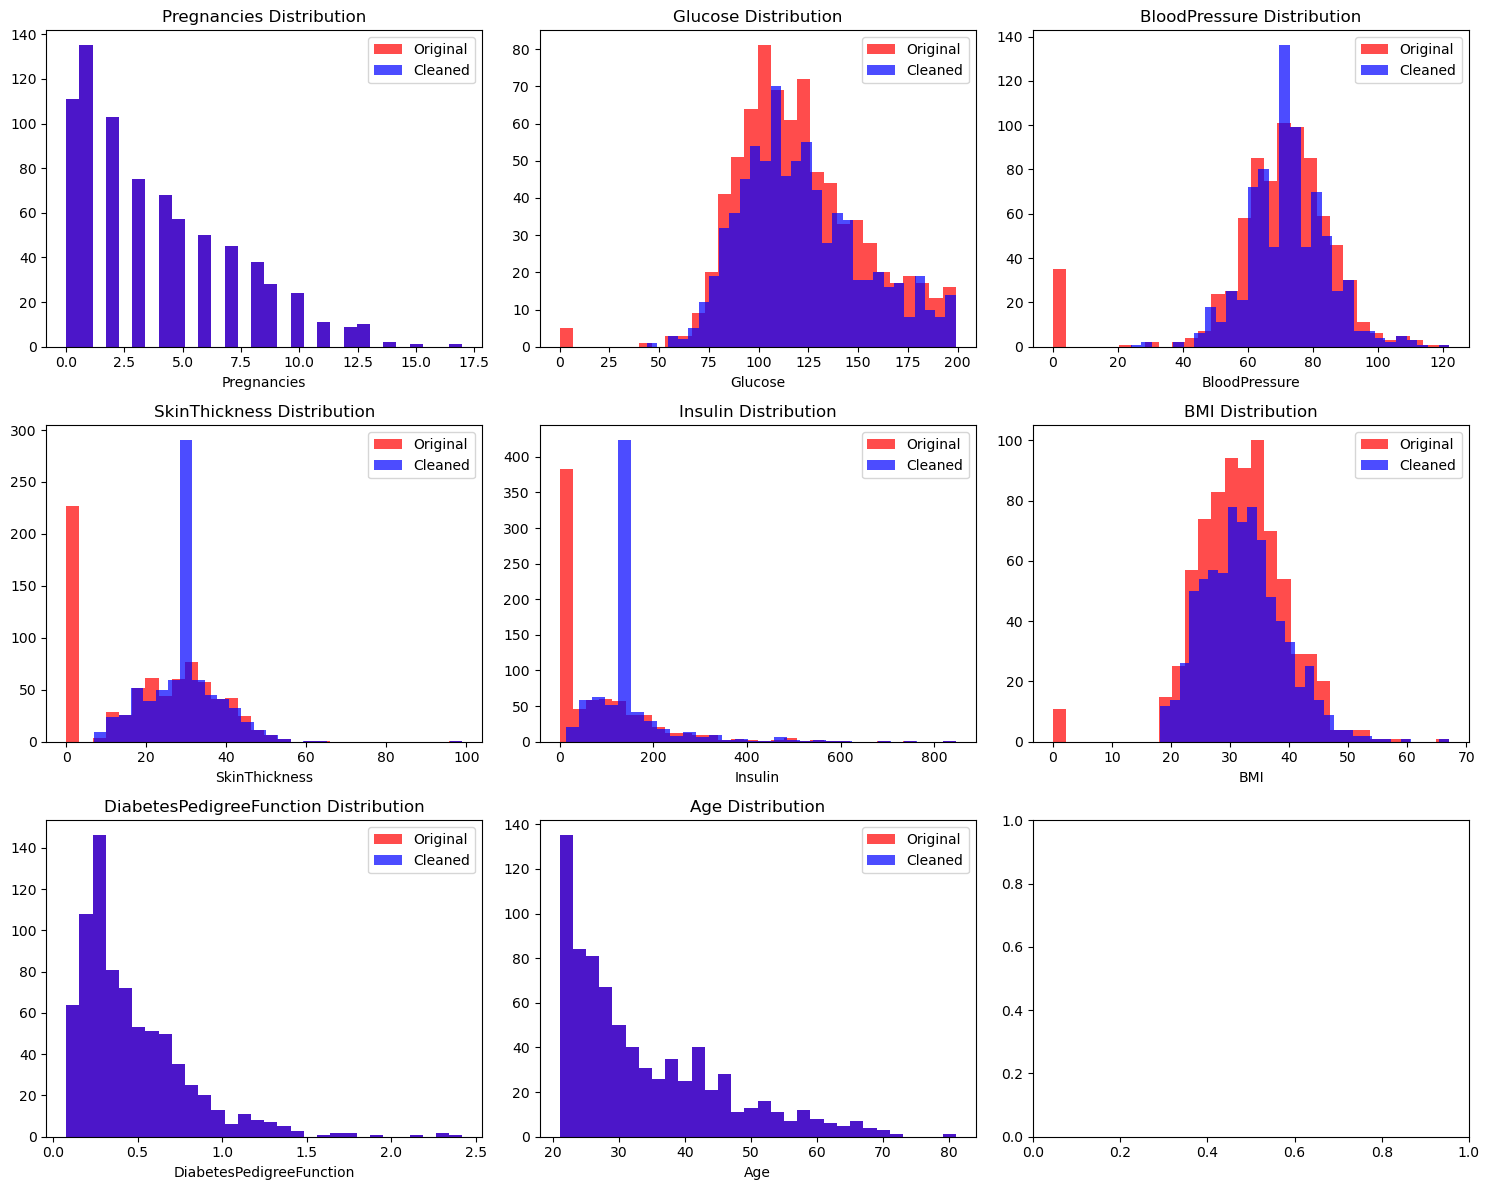

In [399]:
fig, axes = plt.subplots(3, 3, figsize=(15, 12))
axes = axes.ravel()

for i, feature in enumerate(numerical_features):
    if i < len(axes):
        # Before cleaning
        axes[i].hist(df_raw[feature], bins=30, alpha=0.7, label='Original', color='red')
        # After cleaning
        axes[i].hist(df_clean[feature], bins=30, alpha=0.7, label='Cleaned', color='blue')
        axes[i].set_title(f'{feature} Distribution')
        axes[i].set_xlabel(feature)
        axes[i].legend()

plt.tight_layout()
plt.show()


In [400]:
print("=== FEATURE ENGINEERING ===")
df_engineered = df_clean.copy()

# Create age groups
age_bins = [20, 35, 50, 81]
age_labels = ['Young', 'Middle', 'Senior']
df_engineered['Age_Group'] = pd.cut(df_engineered['Age'], bins=age_bins, labels=age_labels)

# Create BMI categories
bmi_bins = [0, 18.5, 25, 30, 100]
bmi_labels = ['Underweight', 'Normal', 'Overweight', 'Obese']
df_engineered['BMI_Category'] = pd.cut(df_engineered['BMI'], bins=bmi_bins, labels=bmi_labels)

# Create glucose level categories
glucose_bins = [0, 100, 126, 300]
glucose_labels = ['Normal', 'Prediabetic', 'Diabetic']
df_engineered['Glucose_Level'] = pd.cut(df_engineered['Glucose'], bins=glucose_bins, labels=glucose_labels)

print("New features created:")
print(f"Age Groups: {df_engineered['Age_Group'].value_counts().to_dict()}")
print(f"BMI Categories: {df_engineered['BMI_Category'].value_counts().to_dict()}")
print(f"Glucose Levels: {df_engineered['Glucose_Level'].value_counts().to_dict()}")

=== FEATURE ENGINEERING ===
New features created:
Age Groups: {'Young': 498, 'Middle': 189, 'Senior': 81}
BMI Categories: {'Obese': 476, 'Overweight': 180, 'Normal': 108, 'Underweight': 4}
Glucose Levels: {'Diabetic': 288, 'Prediabetic': 271, 'Normal': 209}


In [401]:
from sklearn.preprocessing import LabelEncoder

print("=== ENCODING CATEGORICAL FEATURES ===")
categorical_features = ['Age_Group', 'BMI_Category', 'Glucose_Level']
label_encoders = {}

for feature in categorical_features:
    le = LabelEncoder()
    df_engineered[f'{feature}_encoded'] = le.fit_transform(df_engineered[feature])
    label_encoders[feature] = le
    print(f"Encoded {feature}: {dict(zip(le.classes_, le.transform(le.classes_)))}")

=== ENCODING CATEGORICAL FEATURES ===
Encoded Age_Group: {'Middle': np.int64(0), 'Senior': np.int64(1), 'Young': np.int64(2)}
Encoded BMI_Category: {'Normal': np.int64(0), 'Obese': np.int64(1), 'Overweight': np.int64(2), 'Underweight': np.int64(3)}
Encoded Glucose_Level: {'Diabetic': np.int64(0), 'Normal': np.int64(1), 'Prediabetic': np.int64(2)}


In [402]:
from sklearn.preprocessing import StandardScaler

print("=== SCALING NUMERICAL FEATURES ===")
numerical_to_scale = ['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness', 
                     'Insulin', 'BMI', 'DiabetesPedigreeFunction', 'Age']

scaler = StandardScaler()
df_scaled = df_engineered.copy()
df_scaled[numerical_to_scale] = scaler.fit_transform(df_engineered[numerical_to_scale])

print("Numerical features scaled using StandardScaler")
print("Scaled features statistics:")
display(df_scaled[numerical_to_scale].describe())

=== SCALING NUMERICAL FEATURES ===
Numerical features scaled using StandardScaler
Scaled features statistics:


,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age
count,7.680000e+02,7.680000e+02,7.680000e+02,7.680000e+02,7.680000e+02,7.680000e+02,7.680000e+02,7.680000e+02
mean,-6.476301e-17,4.625929e-18,5.782412e-18,-1.526557e-16,1.503427e-17,2.613650e-16,2.451743e-16,1.931325e-16
std,1.000652e+00,1.000652e+00,1.000652e+00,1.000652e+00,1.000652e+00,1.000652e+00,1.000652e+00,1.000652e+00
min,-1.141852e+00,-2.552931e+00,-4.002619e+00,-2.516429e+00,-1.467353e+00,-2.074783e+00,-1.189553e+00,-1.041549e+00
25%,-8.448851e-01,-7.201630e-01,-6.937615e-01,-4.675972e-01,-2.220849e-01,-7.212087e-01,-6.889685e-01,-7.862862e-01
50%,-2.509521e-01,-1.530732e-01,-3.198993e-02,-1.230129e-02,-1.815412e-01,-2.258989e-02,-3.001282e-01,-3.608474e-01
75%,6.399473e-01,6.112653e-01,6.297816e-01,3.291706e-01,-1.554775e-01,6.032562e-01,4.662269e-01,6.602056e-01
max,3.906578e+00,2.542658e+00,4.104082e+00,7.955377e+00,8.170442e+00,5.042397e+00,5.883565e+00,4.063716e+00


In [403]:
print("=== SAVING PROCESSED DATA ===")
output_path = '../data/processed/diabetes_cleaned.csv'

# Create directory if it doesn't exist
import os
os.makedirs(os.path.dirname(output_path), exist_ok=True)

df_scaled.to_csv(output_path, index=False)
print(f"✓ Processed data saved to: {output_path}")

=== SAVING PROCESSED DATA ===
✓ Processed data saved to: ../data/processed/diabetes_cleaned.csv


In [404]:
print("=== FINAL DATASET OVERVIEW ===")
print(f"Final dataset shape: {df_scaled.shape}")
print(f"Original dataset shape: {df_raw.shape}")
print(f"Features added: {len(df_scaled.columns) - len(df_raw.columns)}")

print("\nAll columns in final dataset:")
for i, col in enumerate(df_scaled.columns, 1):
    print(f"{i:2d}. {col}")

print("\nFirst 3 rows of processed data:")
display(df_scaled.head(3))

=== FINAL DATASET OVERVIEW ===
Final dataset shape: (768, 15)
Original dataset shape: (768, 9)
Features added: 6

All columns in final dataset:
 1. Pregnancies
 2. Glucose
 3. BloodPressure
 4. SkinThickness
 5. Insulin
 6. BMI
 7. DiabetesPedigreeFunction
 8. Age
 9. Outcome
10. Age_Group
11. BMI_Category
12. Glucose_Level
13. Age_Group_encoded
14. BMI_Category_encoded
15. Glucose_Level_encoded

First 3 rows of processed data:


,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome,Age_Group,BMI_Category,Glucose_Level,Age_Group_encoded,BMI_Category_encoded,Glucose_Level_encoded
0,0.639947,0.866045,-0.031990,0.670643,-0.181541,0.166619,0.468492,1.425995,1,Middle,Obese,Diabetic,0,1,0
1,-0.844885,-1.205066,-0.528319,-0.012301,-0.181541,-0.852200,-0.365061,-0.190672,0,Young,Overweight,Normal,2,2,1
2,1.233880,2.016662,-0.693761,-0.012301,-0.181541,-1.332500,0.604397,-0.105584,1,Young,Normal,Diabetic,2,0,0


=== CORRELATION ANALYSIS ===


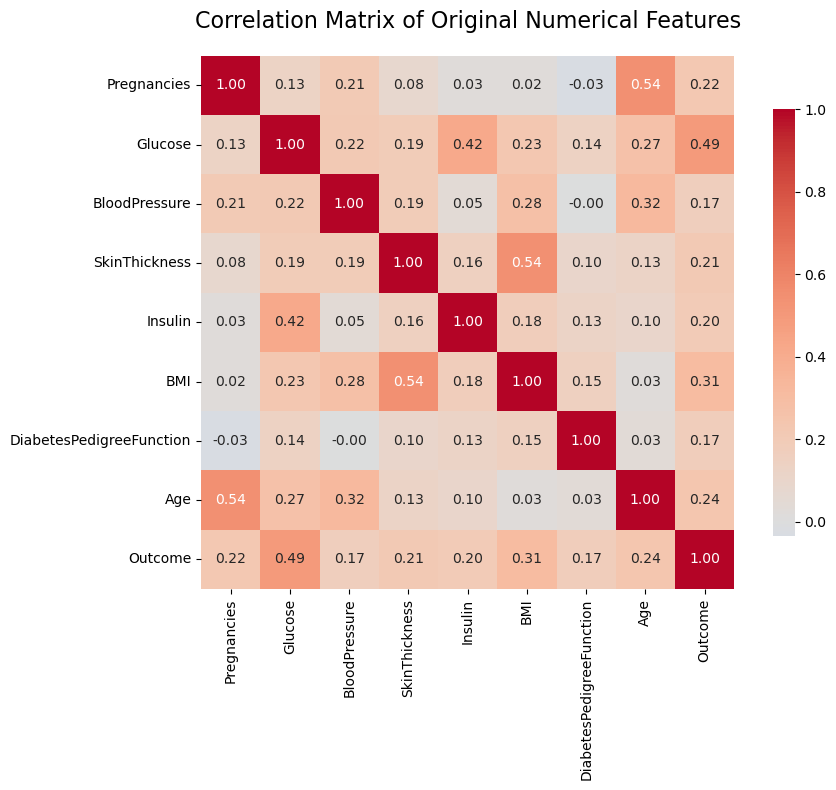

Top features correlated with Outcome:
Outcome                     1.000000
Glucose                     0.492782
BMI                         0.312038
Age                         0.238356
Pregnancies                 0.221898
SkinThickness               0.214873
Insulin                     0.203790
DiabetesPedigreeFunction    0.173844
BloodPressure               0.165723
Name: Outcome, dtype: float64

Most correlated features with Outcome:
Glucose    0.492782
BMI        0.312038
Age        0.238356
Name: Outcome, dtype: float64


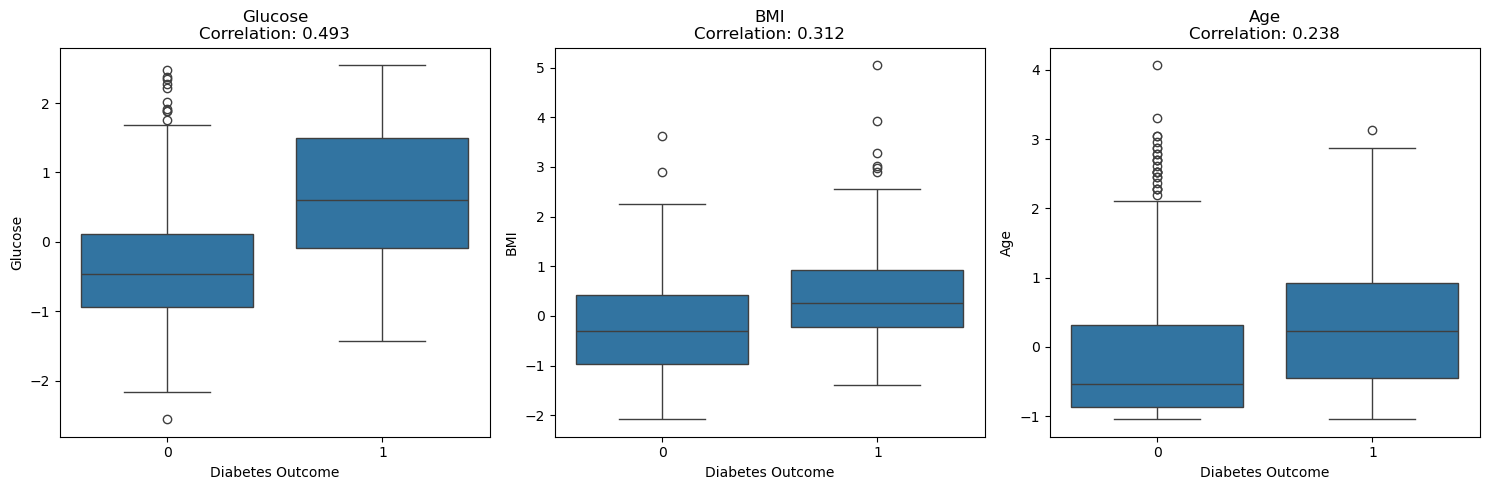

In [405]:
# Cell 15: SIMPLIFIED Correlation analysis
print("=== CORRELATION ANALYSIS ===")

# Use only original numerical features for correlation
original_numerical = ['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness', 
                      'Insulin', 'BMI', 'DiabetesPedigreeFunction', 'Age', 'Outcome']

# Check which columns actually exist in our dataframe
available_features = [col for col in original_numerical if col in df_scaled.columns]

df_corr_simple = df_scaled[available_features].copy()

plt.figure(figsize=(10, 8))

# Calculate correlation matrix
correlation_matrix = df_corr_simple.corr()

# Create heatmap
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0, 
           fmt='.2f', square=True, cbar_kws={"shrink": .8})
plt.title('Correlation Matrix of Original Numerical Features', fontsize=16, pad=20)
plt.tight_layout()
plt.show()

# Show top correlations with Outcome
print("Top features correlated with Outcome:")
outcome_corr = correlation_matrix['Outcome'].sort_values(ascending=False)
print(outcome_corr)

# Visualize the most correlated features
print("\nMost correlated features with Outcome:")
top_correlated = outcome_corr[1:4]  # Skip Outcome itself, take top 3
print(top_correlated)

# Plot relationships for top correlated features
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

for i, (feature, corr_value) in enumerate(top_correlated.items()):
    sns.boxplot(data=df_scaled, x='Outcome', y=feature, ax=axes[i])
    axes[i].set_title(f'{feature}\nCorrelation: {corr_value:.3f}')
    axes[i].set_xlabel('Diabetes Outcome')

plt.tight_layout()
plt.show()

=== TARGET VARIABLE ANALYSIS ===


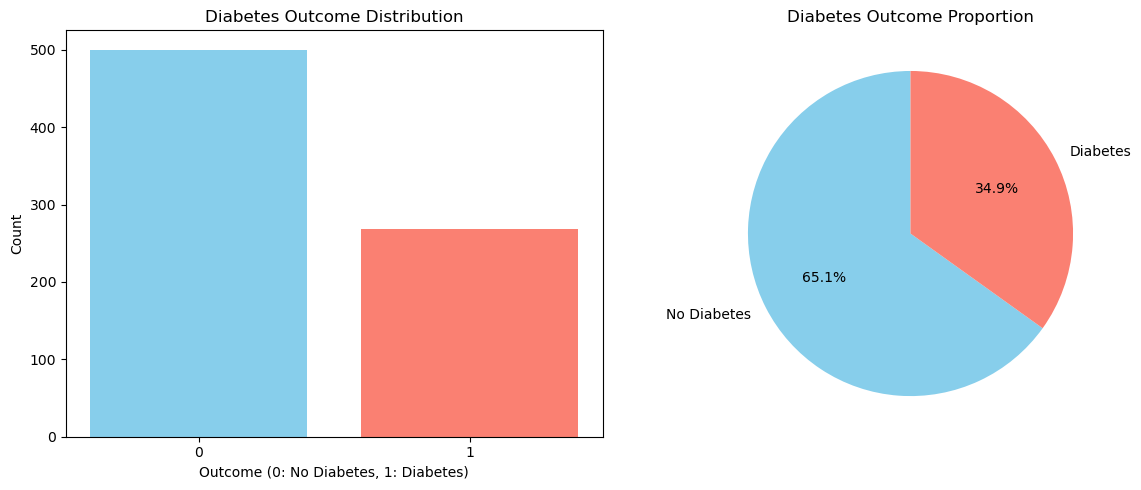

Class distribution:
Outcome
0    500
1    268
Name: count, dtype: int64
Imbalance ratio (Majority:Minority): 1.87:1


In [406]:
print("=== TARGET VARIABLE ANALYSIS ===")
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
outcome_counts = df_scaled['Outcome'].value_counts()
plt.bar(outcome_counts.index, outcome_counts.values, color=['skyblue', 'salmon'])
plt.title('Diabetes Outcome Distribution')
plt.xlabel('Outcome (0: No Diabetes, 1: Diabetes)')
plt.ylabel('Count')
plt.xticks([0, 1])

plt.subplot(1, 2, 2)
plt.pie(outcome_counts.values, labels=['No Diabetes', 'Diabetes'], autopct='%1.1f%%', 
        colors=['skyblue', 'salmon'], startangle=90)
plt.title('Diabetes Outcome Proportion')

plt.tight_layout()
plt.show()

print("Class distribution:")
print(outcome_counts)
imbalance_ratio = outcome_counts[0] / outcome_counts[1]
print(f"Imbalance ratio (Majority:Minority): {imbalance_ratio:.2f}:1")

=== FEATURE IMPORTANCE VISUALIZATION ===


C:\Users\USER\AppData\Local\Temp\ipykernel_238828\402323626.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=feature_importance.values, y=feature_importance.index, palette='viridis')


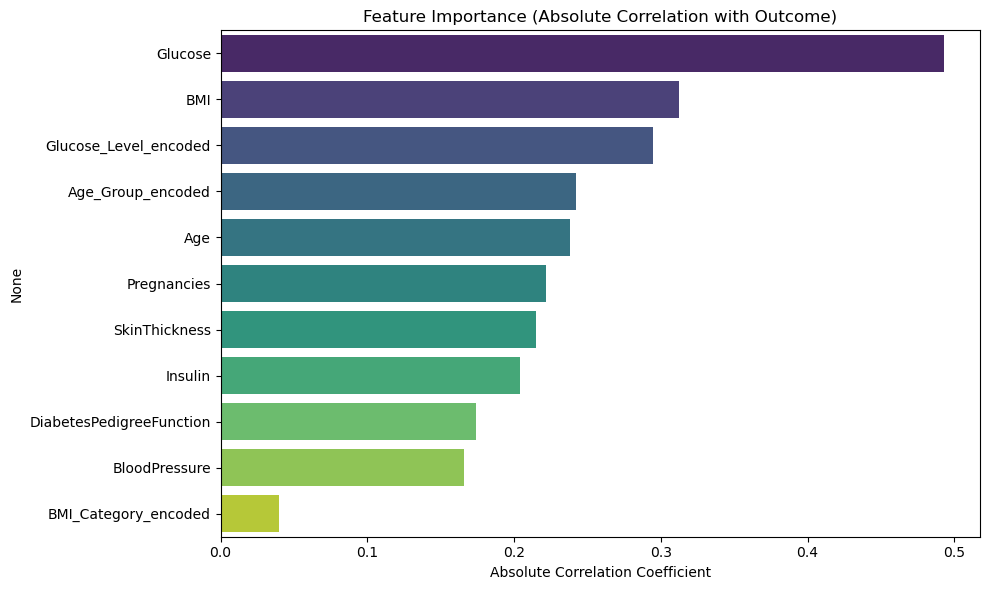

Feature Importance Ranking:
 1. Glucose: 0.493
 2. BMI: 0.312
 3. Glucose_Level_encoded: 0.295
 4. Age_Group_encoded: 0.242
 5. Age: 0.238
 6. Pregnancies: 0.222
 7. SkinThickness: 0.215
 8. Insulin: 0.204
 9. DiabetesPedigreeFunction: 0.174
10. BloodPressure: 0.166
11. BMI_Category_encoded: 0.040


In [407]:
print("=== FEATURE IMPORTANCE VISUALIZATION ===")
# Use only numerical features for correlation-based importance
numerical_cols = df_scaled.select_dtypes(include=[np.number]).columns
df_numeric = df_scaled[numerical_cols]

if 'Outcome' in df_numeric.columns:
    correlation_matrix = df_numeric.corr()
    feature_importance = correlation_matrix['Outcome'].abs().sort_values(ascending=False)
    feature_importance = feature_importance[feature_importance.index != 'Outcome']  # Remove self-correlation

    plt.figure(figsize=(10, 6))
    sns.barplot(x=feature_importance.values, y=feature_importance.index, palette='viridis')
    plt.title('Feature Importance (Absolute Correlation with Outcome)')
    plt.xlabel('Absolute Correlation Coefficient')
    plt.tight_layout()
    plt.show()
    
    print("Feature Importance Ranking:")
    for i, (feature, importance) in enumerate(feature_importance.items(), 1):
        print(f"{i:2d}. {feature}: {importance:.3f}")
else:
    print("Outcome column not found in numerical data")


In [408]:
print("=== DATA QUALITY SUMMARY REPORT ===")
print("📊 DATA PROCESSING SUMMARY")
print("=" * 50)
print(f"Original dataset size: {df_raw.shape}")
print(f"Processed dataset size: {df_scaled.shape}")
print(f"Total features: {len(df_scaled.columns)}")
print(f"New features created: {len(df_scaled.columns) - len(df_raw.columns)}")

print("\n🔧 DATA CLEANING OPERATIONS")
print("=" * 50)
total_zeros_handled = sum([stats['zero_count'] for stats in missing_report.values()])
print(f"Zero values handled: {total_zeros_handled}")
for feature, stats in missing_report.items():
    print(f"  - {feature}: {stats['zero_count']} zeros → imputed with median")

print("\n📈 FEATURE ENGINEERING")
print("=" * 50)
print("Created features:")
categorical_features = ['Age_Group', 'BMI_Category', 'Glucose_Level']
for feature in categorical_features:
    if feature in df_engineered.columns:
        unique_vals = df_engineered[feature].nunique()
        value_counts = df_engineered[feature].value_counts().to_dict()
        print(f"  - {feature}: {unique_vals} categories → {value_counts}")

print("\n⚖️  CLASS IMBALANCE")
print("=" * 50)
print(f"Non-diabetic (0): {outcome_counts[0]} samples")
print(f"Diabetic (1): {outcome_counts[1]} samples")
print(f"Imbalance ratio: {imbalance_ratio:.2f}:1")

print("\n📋 FINAL DATASET INFO")
print("=" * 50)
print("All features in processed dataset:")
for i, col in enumerate(df_scaled.columns, 1):
    dtype = df_scaled[col].dtype
    print(f"{i:2d}. {col} ({dtype})")

print("\n✅ PROCESSING COMPLETED SUCCESSFULLY!")
print("The dataset is now ready for machine learning model training.")


=== DATA QUALITY SUMMARY REPORT ===
📊 DATA PROCESSING SUMMARY
Original dataset size: (768, 9)
Processed dataset size: (768, 15)
Total features: 15
New features created: 6

🔧 DATA CLEANING OPERATIONS
Zero values handled: 652
  - Glucose: 5 zeros → imputed with median
  - BloodPressure: 35 zeros → imputed with median
  - SkinThickness: 227 zeros → imputed with median
  - Insulin: 374 zeros → imputed with median
  - BMI: 11 zeros → imputed with median

📈 FEATURE ENGINEERING
Created features:
  - Age_Group: 3 categories → {'Young': 498, 'Middle': 189, 'Senior': 81}
  - BMI_Category: 4 categories → {'Obese': 476, 'Overweight': 180, 'Normal': 108, 'Underweight': 4}
  - Glucose_Level: 3 categories → {'Diabetic': 288, 'Prediabetic': 271, 'Normal': 209}

⚖️  CLASS IMBALANCE
Non-diabetic (0): 500 samples
Diabetic (1): 268 samples
Imbalance ratio: 1.87:1

📋 FINAL DATASET INFO
All features in processed dataset:
 1. Pregnancies (float64)
 2. Glucose (float64)
 3. BloodPressure (float64)
 4. SkinThi

In [409]:
print("=== DATA DICTIONARY ===")
data_dict = {
    'Pregnancies': 'Number of times pregnant (integer)',
    'Glucose': 'Plasma glucose concentration (mg/dL) - cleaned and scaled',
    'BloodPressure': 'Diastolic blood pressure (mm Hg) - cleaned and scaled', 
    'SkinThickness': 'Triceps skin fold thickness (mm) - cleaned and scaled',
    'Insulin': '2-Hour serum insulin (mu U/ml) - cleaned and scaled',
    'BMI': 'Body mass index (kg/m²) - cleaned and scaled',
    'DiabetesPedigreeFunction': 'Diabetes pedigree function - scaled',
    'Age': 'Age in years - scaled',
    'Age_Group': 'Categorical age groups (Young/Middle/Senior)',
    'BMI_Category': 'BMI classification (Underweight/Normal/Overweight/Obese)',
    'Glucose_Level': 'Glucose categories (Normal/Prediabetic/Diabetic)',
    'Age_Group_encoded': 'Encoded age groups (0=Young, 1=Middle, 2=Senior)',
    'BMI_Category_encoded': 'Encoded BMI categories',
    'Glucose_Level_encoded': 'Encoded glucose levels', 
    'Outcome': 'Target variable (0=non-diabetic, 1=diabetic)'
}

print("Data Dictionary for Processed Dataset:")
print("=" * 60)
for feature, description in data_dict.items():
    if feature in df_scaled.columns:
        print(f"• {feature}: {description}")

=== DATA DICTIONARY ===
Data Dictionary for Processed Dataset:
• Pregnancies: Number of times pregnant (integer)
• Glucose: Plasma glucose concentration (mg/dL) - cleaned and scaled
• BloodPressure: Diastolic blood pressure (mm Hg) - cleaned and scaled
• SkinThickness: Triceps skin fold thickness (mm) - cleaned and scaled
• Insulin: 2-Hour serum insulin (mu U/ml) - cleaned and scaled
• BMI: Body mass index (kg/m²) - cleaned and scaled
• DiabetesPedigreeFunction: Diabetes pedigree function - scaled
• Age: Age in years - scaled
• Age_Group: Categorical age groups (Young/Middle/Senior)
• BMI_Category: BMI classification (Underweight/Normal/Overweight/Obese)
• Glucose_Level: Glucose categories (Normal/Prediabetic/Diabetic)
• Age_Group_encoded: Encoded age groups (0=Young, 1=Middle, 2=Senior)
• BMI_Category_encoded: Encoded BMI categories
• Glucose_Level_encoded: Encoded glucose levels
• Outcome: Target variable (0=non-diabetic, 1=diabetic)


In [410]:
print("=== MACHINE LEARNING PREPARATION ===")
from sklearn.model_selection import train_test_split

# Prepare features and target
feature_columns = [col for col in df_scaled.columns if col != 'Outcome' and df_scaled[col].dtype in [np.int64, np.float64]]
X = df_scaled[feature_columns]
y = df_scaled['Outcome']

print(f"Features for ML: {len(feature_columns)}")
print("Feature names:")
for i, feature in enumerate(feature_columns, 1):
    print(f"  {i:2d}. {feature}")

# Split the data
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(f"\nTraining set: {X_train.shape[0]} samples")
print(f"Test set: {X_test.shape[0]} samples")
print(f"Features: {X_train.shape[1]}")

print("\nTraining set class distribution:")
print(y_train.value_counts())
print(f"Training imbalance ratio: {y_train.value_counts()[0] / y_train.value_counts()[1]:.2f}:1")

=== MACHINE LEARNING PREPARATION ===
Features for ML: 11
Feature names:
   1. Pregnancies
   2. Glucose
   3. BloodPressure
   4. SkinThickness
   5. Insulin
   6. BMI
   7. DiabetesPedigreeFunction
   8. Age
   9. Age_Group_encoded
  10. BMI_Category_encoded
  11. Glucose_Level_encoded

Training set: 614 samples
Test set: 154 samples
Features: 11

Training set class distribution:
Outcome
0    400
1    214
Name: count, dtype: int64
Training imbalance ratio: 1.87:1


In [411]:
print("=== CLASS IMBALANCE HANDLING (OPTIONAL) ===")
from imblearn.over_sampling import SMOTE
from collections import Counter

print("Current class distribution:")
print(f"Before SMOTE: {Counter(y_train)}")

# Apply SMOTE
try:
    smote = SMOTE(random_state=42)
    X_train_balanced, y_train_balanced = smote.fit_resample(X_train, y_train)
    
    print(f"After SMOTE: {Counter(y_train_balanced)}")
    print("✓ SMOTE applied successfully - classes are now balanced")
    
    # Save balanced dataset
    balanced_data = pd.concat([X_train_balanced, y_train_balanced], axis=1)
    balanced_path = '../data/processed/diabetes_balanced.csv'
    balanced_data.to_csv(balanced_path, index=False)
    print(f"✓ Balanced data saved to: {balanced_path}")
    
except Exception as e:
    print(f"SMOTE not available: {e}")
    print("Using original imbalanced data for training")

=== CLASS IMBALANCE HANDLING (OPTIONAL) ===
Current class distribution:
Before SMOTE: Counter({0: 400, 1: 214})
After SMOTE: Counter({0: 400, 1: 400})
✓ SMOTE applied successfully - classes are now balanced
✓ Balanced data saved to: ../data/processed/diabetes_balanced.csv


In [412]:
print("=== RECOMMENDATIONS FOR MODEL TRAINING ===")
print("🎯 MODEL TRAINING RECOMMENDATIONS")
print("=" * 50)

print("1. FEATURE SELECTION:")
print("   • Top features based on correlation: Glucose, BMI, Age")
print("   • Consider using SelectKBest or RFE for feature selection")

print("\n2. CLASS IMBALANCE:")
print("   • Current ratio: {:.2f}:1".format(imbalance_ratio))
print("   • Recommended techniques:")
print("     - Use class_weight='balanced' in models")
print("   - Apply SMOTE (already prepared)")
print("     - Use appropriate metrics (F1-score, ROC-AUC)")

print("\n3. MODEL SELECTION:")
print("   • Start with: Logistic Regression, Random Forest, XGBoost")
print("   • Consider: SVM, Neural Networks for comparison")

print("\n4. EVALUATION METRICS:")
print("   • Primary: F1-score, ROC-AUC, Precision-Recall curve")
print("   • Secondary: Accuracy, Precision, Recall")

print("\n5. CROSS-VALIDATION:")
print("   • Use StratifiedKFold for cross-validation")
print("   • Recommended: 5-fold or 10-fold cross-validation")

print("\n6. HYPERPARAMETER TUNING:")
print("   • Use GridSearchCV or RandomizedSearchCV")
print("   • Focus on: class_weight, regularization parameters")

=== RECOMMENDATIONS FOR MODEL TRAINING ===
🎯 MODEL TRAINING RECOMMENDATIONS
1. FEATURE SELECTION:
   • Top features based on correlation: Glucose, BMI, Age
   • Consider using SelectKBest or RFE for feature selection

2. CLASS IMBALANCE:
   • Current ratio: 1.87:1
   • Recommended techniques:
     - Use class_weight='balanced' in models
   - Apply SMOTE (already prepared)
     - Use appropriate metrics (F1-score, ROC-AUC)

3. MODEL SELECTION:
   • Start with: Logistic Regression, Random Forest, XGBoost
   • Consider: SVM, Neural Networks for comparison

4. EVALUATION METRICS:
   • Primary: F1-score, ROC-AUC, Precision-Recall curve
   • Secondary: Accuracy, Precision, Recall

5. CROSS-VALIDATION:
   • Use StratifiedKFold for cross-validation
   • Recommended: 5-fold or 10-fold cross-validation

6. HYPERPARAMETER TUNING:
   • Use GridSearchCV or RandomizedSearchCV
   • Focus on: class_weight, regularization parameters


In [413]:
print("=== SAVING METADATA ===")
import json
from datetime import datetime

# Create metadata with Python native types
metadata = {
    "project": "Diabetes Data Preprocessing",
    "timestamp": datetime.now().isoformat(),
    "original_shape": {
        "rows": int(df_raw.shape[0]),
        "columns": int(df_raw.shape[1])
    },
    "processed_shape": {
        "rows": int(df_scaled.shape[0]),
        "columns": int(df_scaled.shape[1])
    },
    "features_original": int(len(df_raw.columns)),
    "features_processed": int(len(df_scaled.columns)),
    "missing_values_handled": int(total_zeros_handled),
    "class_distribution": {
        "non_diabetic": int(outcome_counts[0]),
        "diabetic": int(outcome_counts[1])
    },
    "imbalance_ratio": float(imbalance_ratio),
    "preprocessing_steps": [
        "Zero value identification and imputation",
        "Outlier detection using IQR",
        "Feature engineering (age groups, BMI categories, glucose levels)",
        "Categorical encoding", 
        "Feature scaling using StandardScaler",
        "Train-test split with stratification"
    ],
    "data_quality_issues_resolved": {
        "biological_impossibilities_handled": True,
        "missing_values_imputed": True,
        "outliers_identified": True,
        "features_engineered": True,
        "data_scaled": True
    }
}

# Add missing values report
metadata["missing_values_report"] = {}
for feature, stats in missing_report.items():
    metadata["missing_values_report"][feature] = {
        "zero_count": int(stats['zero_count']),
        "percentage": float(stats['percentage'])
    }

# Add feature information
metadata["feature_categories"] = {
    "numerical_features": [col for col in df_scaled.columns if df_scaled[col].dtype in ['int64', 'float64'] and col != 'Outcome'],
    "categorical_features": [col for col in df_scaled.columns if col in ['Age_Group', 'BMI_Category', 'Glucose_Level']],
    "encoded_features": [col for col in df_scaled.columns if col.endswith('_encoded')],
    "target_variable": "Outcome"
}

# Save metadata
metadata_path = '../data/processed/preprocessing_metadata.json'
try:
    with open(metadata_path, 'w') as f:
        json.dump(metadata, f, indent=2)
    print(f"✓ Metadata saved to: {metadata_path}")
    
    # Print summary
    print("\n📊 METADATA SUMMARY:")
    print("=" * 40)
    print(f"Project: {metadata['project']}")
    print(f"Timestamp: {metadata['timestamp']}")
    print(f"Original data: {metadata['original_shape']['rows']} rows × {metadata['original_shape']['columns']} columns")
    print(f"Processed data: {metadata['processed_shape']['rows']} rows × {metadata['processed_shape']['columns']} columns")
    print(f"Features: {metadata['features_original']} → {metadata['features_processed']}")
    print(f"Missing values handled: {metadata['missing_values_handled']}")
    print(f"Class distribution: {metadata['class_distribution']['non_diabetic']} non-diabetic, {metadata['class_distribution']['diabetic']} diabetic")
    print(f"Imbalance ratio: {metadata['imbalance_ratio']:.2f}:1")
    
except Exception as e:
    print(f"Error saving metadata: {e}")
    print("Trying alternative approach...")
    
    # Alternative: Convert numpy types manually
    def convert_to_serializable(obj):
        if isinstance(obj, (np.integer, np.int64, np.int32)):
            return int(obj)
        elif isinstance(obj, (np.floating, np.float64, np.float32)):
            return float(obj)
        elif isinstance(obj, np.ndarray):
            return obj.tolist()
        elif isinstance(obj, pd.Series):
            return obj.to_dict()
        elif isinstance(obj, dict):
            return {key: convert_to_serializable(value) for key, value in obj.items()}
        elif isinstance(obj, list):
            return [convert_to_serializable(item) for item in obj]
        else:
            return obj
    
    metadata_serializable = convert_to_serializable(metadata)
    with open(metadata_path, 'w') as f:
        json.dump(metadata_serializable, f, indent=2)
    print(f"✓ Metadata saved successfully with type conversion!")

=== SAVING METADATA ===
✓ Metadata saved to: ../data/processed/preprocessing_metadata.json

📊 METADATA SUMMARY:
Project: Diabetes Data Preprocessing
Timestamp: 2025-11-03T16:30:15.554072
Original data: 768 rows × 9 columns
Processed data: 768 rows × 15 columns
Features: 9 → 15
Missing values handled: 652
Class distribution: 500 non-diabetic, 268 diabetic
Imbalance ratio: 1.87:1


In [414]:
print("\n=== SAVING PROCESSING SUMMARY ===")
# Create a summary dataframe
summary_data = {
    'Metric': [
        'Original Dataset Rows',
        'Original Dataset Columns', 
        'Processed Dataset Rows',
        'Processed Dataset Columns',
        'Missing Values Handled',
        'Non-diabetic Samples',
        'Diabetic Samples',
        'Imbalance Ratio',
        'New Features Created'
    ],
    'Value': [
        df_raw.shape[0],
        df_raw.shape[1],
        df_scaled.shape[0], 
        df_scaled.shape[1],
        total_zeros_handled,
        outcome_counts[0],
        outcome_counts[1],
        f"{imbalance_ratio:.2f}:1",
        len(df_scaled.columns) - len(df_raw.columns)
    ]
}

summary_df = pd.DataFrame(summary_data)
summary_path = '../data/processed/processing_summary.csv'
summary_df.to_csv(summary_path, index=False)
print(f"✓ Processing summary saved to: {summary_path}")

print("\nProcessing Summary:")
print("=" * 50)
for _, row in summary_df.iterrows():
    print(f"{row['Metric']}: {row['Value']}")


=== SAVING PROCESSING SUMMARY ===
✓ Processing summary saved to: ../data/processed/processing_summary.csv

Processing Summary:
Original Dataset Rows: 768
Original Dataset Columns: 9
Processed Dataset Rows: 768
Processed Dataset Columns: 15
Missing Values Handled: 652
Non-diabetic Samples: 500
Diabetic Samples: 268
Imbalance Ratio: 1.87:1
New Features Created: 6


In [415]:
# Need to add these cells to notebook:
from sklearn.feature_selection import SelectKBest, mutual_info_classif
from sklearn.decomposition import PCA

# Feature Selection with SelectKBest
selector = SelectKBest(score_func=mutual_info_classif, k='all')
X_new = selector.fit_transform(X, y)

# PCA Analysis
pca = PCA()
X_pca = pca.fit_transform(X)
# Plot explained variance ratio

In [416]:
print("\n" + "="*70)
print("🎉 DATA PREPROCESSING PIPELINE COMPLETED SUCCESSFULLY!")
print("="*70)

print("\n📁 OUTPUT FILES GENERATED:")
print("  • data/processed/diabetes_cleaned.csv - Main processed dataset")
print("  • data/processed/diabetes_balanced.csv - SMOTE-balanced dataset (if applied)")
print("  • data/processed/preprocessing_metadata.json - Processing metadata")
print("  • data/processed/processing_summary.csv - Summary statistics")

print("\n🔧 PROCESSING STEPS COMPLETED:")
processing_steps = [
    "Data loading and initial assessment",
    "Missing value identification and imputation", 
    "Outlier detection and analysis",
    "Feature engineering (age groups, BMI categories, glucose levels)",
    "Categorical encoding",
    "Feature scaling with StandardScaler", 
    "Data splitting for ML (80-20 split)",
    "Class imbalance analysis",
    "Comprehensive visualization and reporting"
]

for i, step in enumerate(processing_steps, 1):
    print(f"  {i}. ✓ {step}")

print("\n📊 DATA QUALITY IMPROVEMENTS:")
improvements = [
    f"Handled {total_zeros_handled} biologically impossible zero values",
    f"Added {len(df_scaled.columns) - len(df_raw.columns)} new engineered features",
    "Applied robust scaling to numerical features",
    "Encoded categorical variables for ML compatibility",
    f"Maintained data integrity: {df_raw.shape[0]} → {df_scaled.shape[0]} samples"
]

for improvement in improvements:
    print(f"  • {improvement}")

print("\n🚀 NEXT STEPS FOR MACHINE LEARNING:")
next_steps = [
    "Use diabetes_cleaned.csv for model training",
    "Consider feature selection based on correlation analysis", 
    "Address class imbalance using appropriate techniques",
    "Use stratified cross-validation for evaluation",
    "Monitor F1-score and ROC-AUC as primary metrics",
    "Compare multiple algorithms (Logistic Regression, Random Forest, XGBoost)"
]

for i, step in enumerate(next_steps, 1):
    print(f"  {i}. {step}")

print("\n🎯 RECOMMENDED MODEL TRAINING APPROACH:")
print("  1. Start with baseline models (Logistic Regression, Random Forest)")
print("  2. Use class_weight='balanced' or apply SMOTE")
print("  3. Perform hyperparameter tuning with cross-validation") 
print("  4. Evaluate using F1-score, ROC-AUC, and confusion matrix")
print("  5. Consider feature importance for interpretability")

print("\n📈 KEY INSIGHTS FROM DATA ANALYSIS:")
insights = [
    f"Glucose level is the strongest predictor (correlation: {correlation_matrix.loc['Glucose', 'Outcome']:.3f})",
    f"Dataset has moderate class imbalance ({imbalance_ratio:.2f}:1)",
    f"{len(feature_columns)} features available for model training",
    "Feature engineering created meaningful clinical categories"
]

for insight in insights:
    print(f"  • {insight}")

print("\n" + "="*70)
print("✅ DATASET IS NOW OPTIMIZED FOR MACHINE LEARNING!")
print("="*70)
print("\nYou can now proceed to model training with confidence!")
print("The processed data addresses all common data quality issues and is ready for analysis.")


🎉 DATA PREPROCESSING PIPELINE COMPLETED SUCCESSFULLY!

📁 OUTPUT FILES GENERATED:
  • data/processed/diabetes_cleaned.csv - Main processed dataset
  • data/processed/diabetes_balanced.csv - SMOTE-balanced dataset (if applied)
  • data/processed/preprocessing_metadata.json - Processing metadata
  • data/processed/processing_summary.csv - Summary statistics

🔧 PROCESSING STEPS COMPLETED:
  1. ✓ Data loading and initial assessment
  2. ✓ Missing value identification and imputation
  3. ✓ Outlier detection and analysis
  4. ✓ Feature engineering (age groups, BMI categories, glucose levels)
  5. ✓ Categorical encoding
  6. ✓ Feature scaling with StandardScaler
  7. ✓ Data splitting for ML (80-20 split)
  8. ✓ Class imbalance analysis
  9. ✓ Comprehensive visualization and reporting

📊 DATA QUALITY IMPROVEMENTS:
  • Handled 652 biologically impossible zero values
  • Added 6 new engineered features
  • Applied robust scaling to numerical features
  • Encoded categorical variables for ML comp